In [1]:
import os

from collections import OrderedDict

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import warnings

warnings.filterwarnings('always') 
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [2]:
os.chdir('../Data/')

In [3]:
os.listdir()

['products.csv',
 'orders.csv',
 '.DS_Store',
 'order_products__train.csv',
 'departments.csv',
 'aisles.csv',
 'order_products__prior.csv',
 'sample_submission.csv']

## Loading our Datasets

In [4]:
prod_df = pd.read_csv('products.csv')

In [5]:
ord_df = pd.read_csv('orders.csv')

In [6]:
ord_df.drop('eval_set', axis=1,inplace=True)

In [7]:
dep_df = pd.read_csv('departments.csv')

In [8]:
ais_df = pd.read_csv('aisles.csv')

We'll treat the prior as our training set and the train as our test set.  
Prior - 3214874 (our training set)  
Train - 131209 (our test set)

In [9]:
ord_prod_train_df = pd.read_csv('order_products__prior.csv')

In [10]:
ord_prod_test_df = pd.read_csv('order_products__train.csv')

Here we're combining the order/product information with user information by merging the `order_products` table with the `orders` table.

In [11]:
ord_prod_train_df = ord_prod_train_df.merge(ord_df, on='order_id')
ord_prod_test_df = ord_prod_test_df.merge(ord_df, on='order_id')

## Preparing our Test Data

### Organizing the data

Below I've created a new DataFrame that aggregared user-product info. I've also taken this as an opportunity to create a count of the number of orders for each product.

In [12]:
df_user_product = (ord_prod_train_df.groupby(['product_id','user_id'],as_index=False) 
                              .agg({'order_id':'count'}) 
                              .rename(columns={'order_id':'num_ord_per_user_per_prod'}))

test_ids = ord_prod_test_df['user_id'].unique() 
df = df_user_product[df_user_product['user_id'].isin(test_ids)]
df.head()

,product_id,user_id,num_ord_per_user_per_prod
0,1,138,2
1,1,709,1
3,1,777,1
6,1,1052,2
9,1,1494,3


This is a DataFrame containing every single user_id, for every user_id you have every product they've ever ordered. The features of those products will be created mostly by grouping by user_id (i.e. values for features will be user_id specific and, within that, item specific).
One column for this DataFrame is labeled `in_cart` and will be our target variable during testing.

In [13]:
test_carts = (ord_prod_test_df.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df = df.merge(test_carts, on='user_id')
df['in_cart'] = (df.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

### Quick look at our target

In [14]:
orders = df.in_cart.value_counts()
print('Total unique combinations of product orders for total users =',orders[0]+orders[1])
print('Items not re-ordered in latest order =',orders[0])
print('Items re-ordered in latest order =',orders[1])
print('This means that there are 8474661 unique user_id/product_id combinations \
and that, of that, those users re-ordered 828824 of those items \
in their last order.')

Total unique combinations of product orders for total users = 8474661
Items not re-ordered in latest order = 7645837
Items re-ordered in latest order = 828824
This means that there are 8474661 unique user_id/product_id combinations and that, of that, those users re-ordered 828824 of those items in their last order.


In [15]:
print('There are',df.user_id.nunique(), 'unique users.')

There are 131209 unique users.


Ratio of non-re-orders v.s. re-orders.  
This shows a significant class imbalance.

0    0.9022
1    0.0978
Name: in_cart, dtype: float64


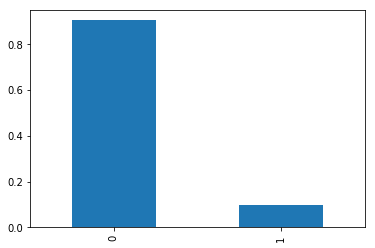

In [16]:
target_pcts = df.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

## Pickle Data

In [17]:
# pd.to_pickle(df,'00_merged_prod_order')